Perform Exploratory Data Analysis (EDA) analysis on the following:

- Summary Statistics & Missing-Value Report


In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Reading csv data using pandas

In [26]:
df = pd.read_csv('../data/benin-malanville.csv')
print(df.head())

          Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0  2021-08-09 00:01 -1.2 -0.2 -1.1   0.0   0.0  26.2  93.4  0.0     0.4   
1  2021-08-09 00:02 -1.1 -0.2 -1.1   0.0   0.0  26.2  93.6  0.0     0.0   
2  2021-08-09 00:03 -1.1 -0.2 -1.1   0.0   0.0  26.2  93.7  0.3     1.1   
3  2021-08-09 00:04 -1.1 -0.1 -1.0   0.0   0.0  26.2  93.3  0.2     0.7   
4  2021-08-09 00:05 -1.0 -0.1 -1.0   0.0   0.0  26.2  93.3  0.1     0.7   

   WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  TModB  \
0      0.1  122.1      0.0  998         0            0.0   26.3   26.2   
1      0.0    0.0      0.0  998         0            0.0   26.3   26.2   
2      0.5  124.6      1.5  997         0            0.0   26.4   26.2   
3      0.4  120.3      1.3  997         0            0.0   26.4   26.3   
4      0.3  113.2      1.0  997         0            0.0   26.4   26.3   

   Comments  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  


Summary Statistics & Missing-Value Report

In [7]:
# 1. Describe all numeric columns
print("--- Descriptive Statistics for Numeric Columns ---")
print(df.describe())

# 2. Calculate the number of missing values per column
print("\n--- Missing Value Counts per Column ---")
missing_counts = df.isna().sum()
print(missing_counts)

# 3. Identify columns with > 5% nulls
total_rows = len(df)
null_percentage_threshold = 0.05  # 5%

columns_with_high_nulls = missing_counts[missing_counts /
                                            total_rows > null_percentage_threshold].index.tolist()

print("\n--- Columns with > 5% Missing Values ---")
if columns_with_high_nulls:
    print(columns_with_high_nulls)
else:
    print("No columns have more than 5% missing values.")


--- Descriptive Statistics for Numeric Columns ---
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      240.559452     167.187516     115.358961     236.589496   
std       331.131327     261.710501     158.691074     326.894859   
min       -12.900000      -7.800000     -12.600000       0.000000   
25%        -2.000000      -0.500000      -2.100000       0.000000   
50%         1.800000      -0.100000       1.600000       4.500000   
75%       483.400000     314.200000     216.300000     463.700000   
max      1413.000000     952.300000     759.200000    1342.300000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      228.883576      28.179683      54.487969       2.121113   
std       316.536515       5.924297      28.073069       1.603466   
min         0.000000      11.000000       2.100000 

Outlier Detection & Basic Cleaning

In [13]:
"""
Looks for missing values, potential outliers, and basic statistics
for the specified columns in the DataFrame.

Args:
    df (pd.DataFrame): The input DataFrame.
    columns_to_inspect (list): A list of column names to inspect.
"""
columns_to_inspect = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
for col in columns_to_inspect:
    print(f"\n--- Column: {col} ---")

    # 1. Missing Values
    missing_count = df[col].isnull().sum()
    missing_percentage = (missing_count / len(df)) * 100
    print(f"Missing Value Count: {missing_count}")
    print(f"Missing Value Percentage: {missing_percentage:.2f}%")

    # 2. Basic Statistics
    print("\n--- Basic Statistics ---")
    print(df[col].describe())

    # 3. Outlier Detection (using IQR and Visualization)
    print("\n--- Outlier Detection (IQR) ---")
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_iqr = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Number of potential outliers (IQR): {len(outliers_iqr)}")
    if not outliers_iqr.empty:
        print(f"Example outlier values:\n{outliers_iqr[col].head()}")

    # 5. Potential Incorrect Entries (based on domain knowledge - adjust as needed)
    print("\n--- Potential Incorrect Entries ---")
    if col in ['GHI', 'DNI', 'DHI', 'ModA', 'ModB']:
        # Allowing a small negative due to potential sensor noise
        negative_values = df[df[col] < -5][col]
        if not negative_values.empty:
            print(
                f"Number of potentially incorrect (significantly negative) values: {len(negative_values)}")
            print(f"Example negative values:\n{negative_values.head()}")
        else:
            print("No significantly negative values found.")
    elif col in ['WS', 'WSgust']:
        # Wind speed should generally be non-negative
        negative_ws = df[df[col] < 0][col]
        if not negative_ws.empty:
            print(
                f"Number of potentially incorrect (negative) wind speed values: {len(negative_ws)}")
            print(
                f"Example negative wind speed values:\n{negative_ws.head()}")
        else:
            print("No negative wind speed values found.")


--- Column: GHI ---
Missing Value Count: 0
Missing Value Percentage: 0.00%

--- Basic Statistics ---
count    525600.000000
mean        240.559452
std         331.131327
min         -12.900000
25%          -2.000000
50%           1.800000
75%         483.400000
max        1413.000000
Name: GHI, dtype: float64

--- Outlier Detection (IQR) ---
Number of potential outliers (IQR): 145
Example outlier values:
671    1274.0
674    1349.0
676    1334.0
849    1253.0
850    1324.0
Name: GHI, dtype: float64

--- Potential Incorrect Entries ---
Number of potentially incorrect (significantly negative) values: 36164
Example negative values:
10081   -5.2
10082   -5.6
10083   -5.9
10084   -5.6
14358   -5.5
Name: GHI, dtype: float64

--- Column: DNI ---
Missing Value Count: 0
Missing Value Percentage: 0.00%

--- Basic Statistics ---
count    525600.000000
mean        167.187516
std         261.710501
min          -7.800000
25%          -0.500000
50%          -0.100000
75%         314.200000
max     

    Computes Z-scores for specified columns and flags rows where the absolute
    Z-score is greater than 3.

In [27]:
def flag_zscore_outliers(df, columns):
    """
    Computes Z-scores for specified columns and flags rows where the absolute
    Z-score is greater than 3.

    Args:
        df (pd.DataFrame): The input DataFrame.
        columns (list): A list of column names to compute Z-scores for.

    Returns:
        pd.DataFrame: The DataFrame with a new boolean column 'is_zscore_outlier'
                      indicating if any of the specified columns have a |Z|>3.
    """
    df['is_zscore_outlier'] = False  # Initialize the flag column

    for col in columns:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            # Calculate Z-scores, handling potential NaN values
            z_scores = np.abs(stats.zscore(df[col], nan_policy='omit'))

            # Flag rows where the absolute Z-score is greater than 3 for the current column
            outlier_mask = z_scores > 3
            df.loc[outlier_mask, 'is_zscore_outlier'] = True
        else:
            print(
                f"Warning: Column '{col}' not found or is not numeric. Skipping Z-score calculation.")

    return df


# Specify the columns for Z-score calculation
zscore_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Assuming your DataFrame is named 'df'
df_with_zscore_flags = flag_zscore_outliers(df.copy(), zscore_columns)

# Display the first few rows with the outlier flag
print(df_with_zscore_flags[['Timestamp'] +
      zscore_columns + ['is_zscore_outlier']].head())

# You can also see how many outliers were flagged:
num_zscore_outliers = df_with_zscore_flags['is_zscore_outlier'].sum()
print(
    f"\nNumber of rows flagged as Z-score outliers (|Z| > 3): {num_zscore_outliers}")

          Timestamp  GHI  DNI  DHI  ModA  ModB   WS  WSgust  is_zscore_outlier
0  2021-08-09 00:01 -1.2 -0.2 -1.1   0.0   0.0  0.0     0.4              False
1  2021-08-09 00:02 -1.1 -0.2 -1.1   0.0   0.0  0.0     0.0              False
2  2021-08-09 00:03 -1.1 -0.2 -1.1   0.0   0.0  0.3     1.1              False
3  2021-08-09 00:04 -1.1 -0.1 -1.0   0.0   0.0  0.2     0.7              False
4  2021-08-09 00:05 -1.0 -0.1 -1.0   0.0   0.0  0.1     0.7              False

Number of rows flagged as Z-score outliers (|Z| > 3): 7740


In [28]:
def handle_missing_values(df, key_columns, imputation_strategy='median'):
    """
    Drops rows with missing values or imputes them using the median
    for the specified key columns.

    Args:
        df (pd.DataFrame): The input DataFrame.
        key_columns (list): A list of column names where missing values should be handled.
        imputation_strategy (str, optional): Strategy for handling missing values.
                                             'drop' to remove rows with any missing value in key columns.
                                             'median' to impute missing values with the median of the column.
                                             Defaults to 'median'.

    Returns:
        pd.DataFrame: The DataFrame with missing values handled in the key columns.
    """
    df_handled = df.copy()  # Work on a copy

    print(f"--- Handling Missing Values in Columns: {key_columns} ---")
    print(f"Initial number of rows: {len(df_handled)}")
    print("\nMissing values before handling:")
    print(df_handled[key_columns].isnull().sum())

    for col in key_columns:
        if col in df_handled.columns:
            if imputation_strategy.lower() == 'drop':
                initial_rows = len(df_handled)
                df_handled.dropna(subset=[col], inplace=True)
                rows_dropped = initial_rows - len(df_handled)
                print(
                    f"Dropped {rows_dropped} rows with missing values in column '{col}'.")
            elif imputation_strategy.lower() == 'median':
                median_val = df_handled[col].median()
                df_handled[col].fillna(median_val, inplace=True)
                print(
                    f"Imputed missing values in column '{col}' with median: {median_val:.2f}")
            else:
                print(
                    f"Warning: Unknown imputation strategy '{imputation_strategy}'. Skipping column '{col}'.")
        else:
            print(f"Warning: Key column '{col}' not found in DataFrame.")

    print(f"\nNumber of rows after handling missing values: {len(df_handled)}")
    print("\nMissing values after handling:")
    print(df_handled[key_columns].isnull().sum())

    return df_handled


# Specify the key columns where you want to handle missing values
key_columns_to_handle = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Assuming your DataFrame is named 'df'

# Option 1: Drop rows with missing values in key columns
df_dropped_na = handle_missing_values(
    df.copy(), key_columns_to_handle, imputation_strategy='drop')
print("\nDataFrame after dropping missing values:")
print(df_dropped_na[key_columns_to_handle].head())

# Option 2: Impute missing values with the median in key columns
df_imputed_median = handle_missing_values(
    df.copy(), key_columns_to_handle, imputation_strategy='median')
print("\nDataFrame after imputing missing values with median:")
print(df_imputed_median[key_columns_to_handle].head())

--- Handling Missing Values in Columns: ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust'] ---
Initial number of rows: 525600

Missing values before handling:
GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64
Dropped 0 rows with missing values in column 'GHI'.
Dropped 0 rows with missing values in column 'DNI'.
Dropped 0 rows with missing values in column 'DHI'.
Dropped 0 rows with missing values in column 'ModA'.
Dropped 0 rows with missing values in column 'ModB'.
Dropped 0 rows with missing values in column 'WS'.
Dropped 0 rows with missing values in column 'WSgust'.

Number of rows after handling missing values: 525600

Missing values after handling:
GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64

DataFrame after dropping missing values:
   GHI  DNI  DHI  ModA  ModB   WS  WSgust
0 -1.2 -0.2 -1.1   0.0   0.0  0.0     0.4
1 -1.1 -0.2 -1.1   0.0   0.0  0.0     0.0
2 -1.1 -0.2 -1.1   0.0

/tmp/ipykernel_179618/2226578486.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_handled[col].fillna(median_val, inplace=True)
/tmp/ipykernel_179618/2226578486.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

    Exports the cleaned DataFrame to a CSV file in the specified directory.

In [17]:


filename = "benin_clean.csv"
filepath = os.path.join("../data/", filename)

# Export the DataFrame to CSV
df.to_csv(filepath, index=False)

print(
    f"Ensure the '{filepath}/' directory is in your .gitignore file to avoid committing CSVs.")

Ensure the '../data/benin_clean.csv/' directory is in your .gitignore file to avoid committing CSVs.


Time Series Analysis
Line or bar charts of GHI, DNI, DHI, Tamb vs. Timestamp.

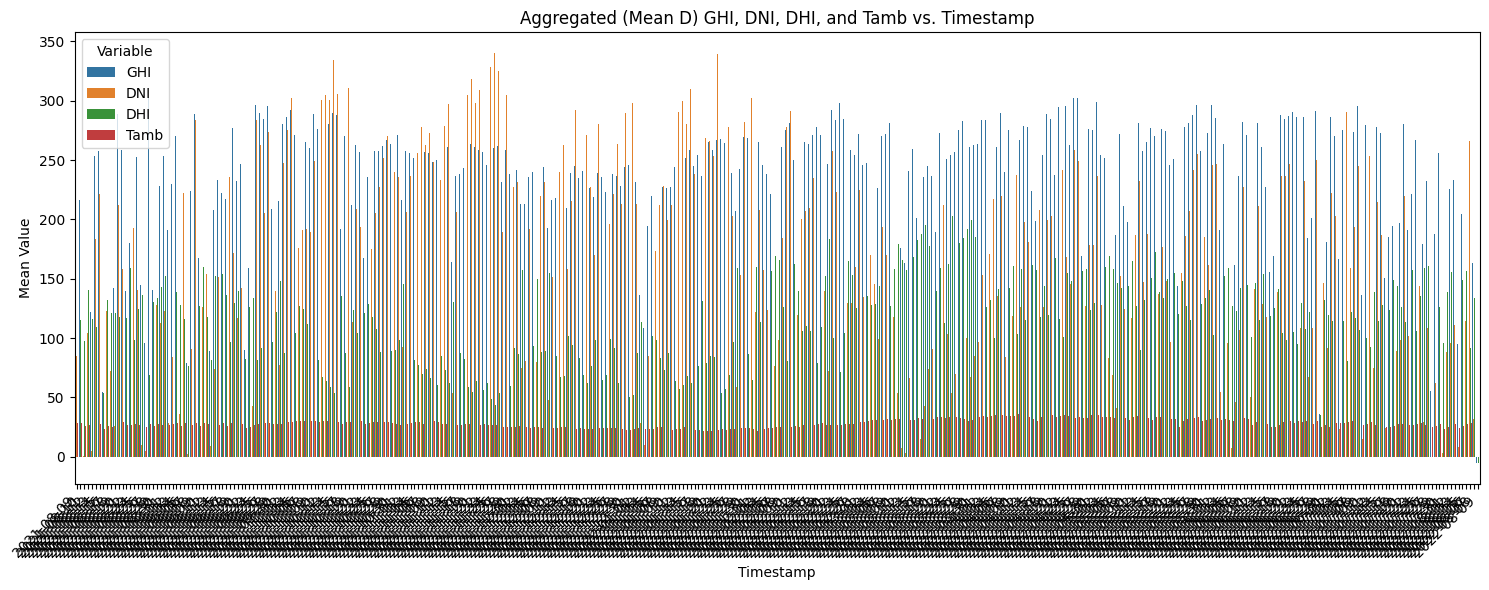

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_irradiance_and_temperature_bar(df, time_agg='D'):
    """
    Generates a bar chart of aggregated (e.g., daily) GHI, DNI, DHI, and Tamb
    against Timestamp.

    Args:
        df (pd.DataFrame): The DataFrame containing the data with a 'Timestamp' column
                           and 'GHI', 'DNI', 'DHI', and 'Tamb' columns.
        time_agg (str, optional): The time aggregation frequency for the bar chart
                                   (e.g., 'D' for daily, 'W' for weekly, 'M' for monthly).
                                   Defaults to 'D'.
    """
    if 'Timestamp' not in df.columns:
        print("Error: 'Timestamp' column not found in DataFrame.")
        return

    if not pd.api.types.is_datetime64_any_dtype(df['Timestamp']):
        try:
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            # Set Timestamp as index for resampling
            df = df.set_index('Timestamp')
        except ValueError:
            print("Error: 'Timestamp' column could not be converted to datetime.")
            return
    else:
        df = df.set_index('Timestamp')  # Set Timestamp as index for resampling

    # Aggregate the data by the specified time frequency
    aggregated_df = df[['GHI', 'DNI', 'DHI', 'Tamb']].resample(time_agg).mean()
    aggregated_df['Time'] = aggregated_df.index.strftime(
        '%Y-%m-%d')  # Format for x-axis labels

    # Melt the DataFrame for easier plotting with Seaborn
    melted_df = pd.melt(aggregated_df, id_vars=[
                        'Time'], var_name='Variable', value_name='Value')

    plt.figure(figsize=(15, 6))
    sns.barplot(x='Time', y='Value', hue='Variable', data=melted_df)
    plt.title(
        f'Aggregated (Mean {time_agg}) GHI, DNI, DHI, and Tamb vs. Timestamp')
    plt.xlabel('Timestamp')
    plt.ylabel('Mean Value')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# Example Usage:
# Assuming you have a DataFrame named 'df' with 'Timestamp', 'GHI', 'DNI', 'DHI', and 'Tamb' columns
plot_irradiance_and_temperature_bar(
    df.copy(), time_agg='D')  # Daily aggregation
# You can try other aggregations like weekly ('W') or monthly ('M'):
# plot_irradiance_and_temperature_bar(df.copy(), time_agg='W')
# plot_irradiance_and_temperature_bar(df.copy(), time_agg='M')

<Figure size 1000x600 with 0 Axes>

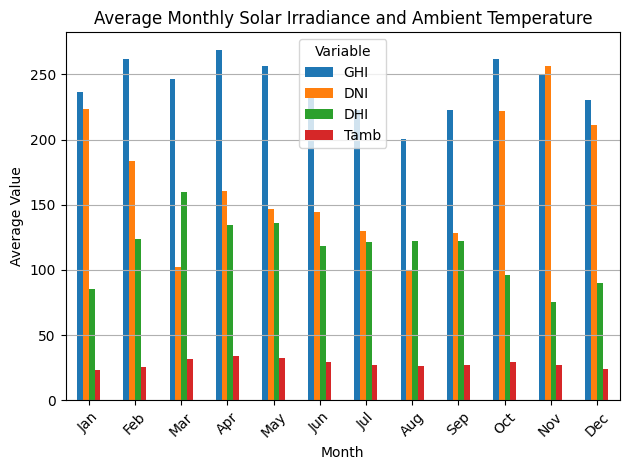


Observations on Monthly Patterns:
 - Look for months with consistently higher solar irradiance (GHI, DNI, DHI), indicating better potential.
 - Observe if temperature (Tamb) peaks in the same months as high irradiance, which might affect efficiency.
 - Note any seasonal variations or trends across the year.


<Figure size 1000x600 with 0 Axes>

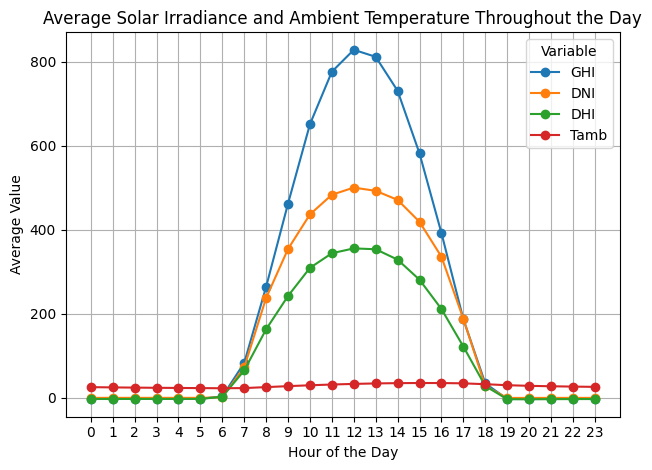


Observations on Daily Trends:
 - Identify the hours with peak solar irradiance. This is crucial for energy generation potential.
 - Observe how temperature changes throughout the day and its correlation with irradiance.
 - Look for any unusual dips or spikes in irradiance or temperature during specific hours.

Potential Anomalies (Simple Z-score based peaks and large fluctuations):

Potential Peaks in GHI:
671    1274.0
674    1349.0
676    1334.0
849    1253.0
850    1324.0
Name: GHI, dtype: float64

Potential Large Fluctuations in GHI:
461     98.2
467    112.5
469    138.1
480    177.4
489    203.5
Name: GHI, dtype: float64

Potential Large Fluctuations in DNI:
461    65.2
462    37.9
464    25.6
467    45.0
469    92.5
Name: DNI, dtype: float64

Potential Peaks in DHI:
670    610.6
671    615.2
672    612.8
673    593.2
674    618.0
Name: DHI, dtype: float64

Potential Large Fluctuations in DHI:
549    299.4
550    314.0
551    328.2
552    344.9
553    358.7
Name: DHI, dtype: flo

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def analyze_temporal_patterns(df):
    """
    Observes patterns by month, trends throughout the day, and anomalies
    in solar irradiance (GHI, DNI, DHI) and ambient temperature (Tamb).

    Args:
        df (pd.DataFrame): The DataFrame with 'Timestamp', 'GHI', 'DNI', 'DHI', and 'Tamb' columns.
    """
    if 'Timestamp' not in df.columns:
        print("Error: 'Timestamp' column not found in DataFrame.")
        return

    if not pd.api.types.is_datetime64_any_dtype(df['Timestamp']):
        try:
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        except ValueError:
            print("Error: 'Timestamp' column could not be converted to datetime.")
            return

    df['Month'] = df['Timestamp'].dt.month
    df['Hour'] = df['Timestamp'].dt.hour

    # 1. Patterns by Month (Monthly Averages)
    monthly_avg = df.groupby('Month')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_avg.index = [months[i - 1] for i in monthly_avg.index]

    plt.figure(figsize=(10, 6))
    monthly_avg.plot(kind='bar')
    plt.title('Average Monthly Solar Irradiance and Ambient Temperature')
    plt.xlabel('Month')
    plt.ylabel('Average Value')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.legend(title='Variable')
    plt.tight_layout()
    plt.show()

    print("\nObservations on Monthly Patterns:")
    print(" - Look for months with consistently higher solar irradiance (GHI, DNI, DHI), indicating better potential.")
    print(" - Observe if temperature (Tamb) peaks in the same months as high irradiance, which might affect efficiency.")
    print(" - Note any seasonal variations or trends across the year.")

    # 2. Trends Throughout the Day (Hourly Averages)
    hourly_avg = df.groupby('Hour')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

    plt.figure(figsize=(10, 6))
    hourly_avg.plot(kind='line', marker='o')
    plt.title('Average Solar Irradiance and Ambient Temperature Throughout the Day')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Value')
    plt.xticks(range(24))
    plt.grid(True)
    plt.legend(title='Variable')
    plt.tight_layout()
    plt.show()

    print("\nObservations on Daily Trends:")
    print(" - Identify the hours with peak solar irradiance. This is crucial for energy generation potential.")
    print(" - Observe how temperature changes throughout the day and its correlation with irradiance.")
    print(" - Look for any unusual dips or spikes in irradiance or temperature during specific hours.")

    # 3. Anomalies (Identifying Peaks and Fluctuations - Simple Approach)
    # You can implement more sophisticated anomaly detection techniques if needed.
    def find_peaks(series, threshold_multiplier=3):
        mean = series.mean()
        std = series.std()
        peaks = series[series > mean + threshold_multiplier * std]
        return peaks

    def find_fluctuations(series, threshold_diff=10):
        diff = series.diff().abs()
        fluctuations = series[diff > threshold_diff]
        return fluctuations

    print("\nPotential Anomalies (Simple Z-score based peaks and large fluctuations):")
    for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
        peaks = find_peaks(df[col])
        if not peaks.empty:
            print(f"\nPotential Peaks in {col}:")
            print(peaks.head())

        fluctuations = find_fluctuations(df[col])
        if not fluctuations.empty:
            print(f"\nPotential Large Fluctuations in {col}:")
            print(fluctuations.head())

    print("\nObservations on Anomalies:")
    print(" - High peaks in solar irradiance could indicate ideal conditions or sensor errors.")
    print(" - Rapid and large temperature fluctuations might point to weather events or data issues.")
    print(" - Investigate the context of any identified anomalies by looking at the corresponding timestamps.")


# Example Usage:
# Assuming you have a DataFrame named 'df' with 'Timestamp', 'GHI', 'DNI', 'DHI', and 'Tamb' columns
analyze_temporal_patterns(df.copy())

Cleaning Impact
Group by Cleaning flag and plot average ModA & ModB pre/post-clean.

<Figure size 800x600 with 0 Axes>

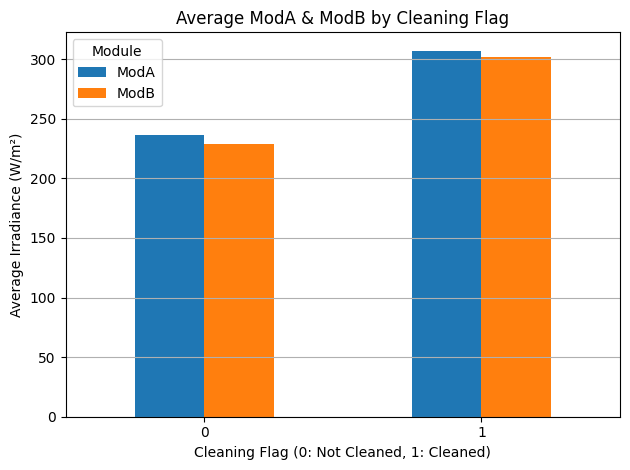


Observations on Cleaning Impact (Average Values):
 - Average ModA on non-cleaning timestamps: 236.52 W/m²
 - Average ModA on cleaning timestamps: 307.23 W/m²
   => Change in ModA: 70.71 W/m² (29.89%)

 - Average ModB on non-cleaning timestamps: 228.82 W/m²
 - Average ModB on cleaning timestamps: 301.97 W/m²
   => Change in ModB: 73.16 W/m² (31.97%)

 - The results suggest that cleaning events are associated with an increase in the average readings of both ModA and ModB.


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_cleaning_impact(df):
    """
    Groups the DataFrame by the 'Cleaning' flag and plots the average ModA and ModB
    for each group (0: not cleaned, 1: cleaned). This provides a simplified
    view of the average module readings on days with and without cleaning events.

    Note: This analysis assumes the 'Cleaning' flag indicates whether a cleaning
          event occurred on that specific timestamp. A more precise pre/post-clean
          analysis would require identifying the exact timestamps of cleaning
          events and comparing the module readings immediately before and after.

    Args:
        df (pd.DataFrame): The DataFrame with 'Cleaning', 'ModA', and 'ModB' columns.
    """
    if 'Cleaning' not in df.columns or 'ModA' not in df.columns or 'ModB' not in df.columns:
        print("Error: DataFrame must contain 'Cleaning', 'ModA', and 'ModB' columns.")
        return

    # Group by the 'Cleaning' flag and calculate the mean of ModA and ModB
    cleaning_impact = df.groupby('Cleaning')[['ModA', 'ModB']].mean()

    # Plot the results
    plt.figure(figsize=(8, 6))
    cleaning_impact.plot(kind='bar')
    plt.title('Average ModA & ModB by Cleaning Flag')
    plt.xlabel('Cleaning Flag (0: Not Cleaned, 1: Cleaned)')
    plt.ylabel('Average Irradiance (W/m²)')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.legend(title='Module')
    plt.tight_layout()
    plt.show()

    print("\nObservations on Cleaning Impact (Average Values):")
    if 0 in cleaning_impact.index and 1 in cleaning_impact.index:
        delta_ModA = cleaning_impact.loc[1,
                                         'ModA'] - cleaning_impact.loc[0, 'ModA']
        delta_ModB = cleaning_impact.loc[1,
                                         'ModB'] - cleaning_impact.loc[0, 'ModB']
        percent_change_ModA = (
            delta_ModA / cleaning_impact.loc[0, 'ModA']) * 100 if cleaning_impact.loc[0, 'ModA'] != 0 else 0
        percent_change_ModB = (
            delta_ModB / cleaning_impact.loc[0, 'ModB']) * 100 if cleaning_impact.loc[0, 'ModB'] != 0 else 0

        print(
            f" - Average ModA on non-cleaning timestamps: {cleaning_impact.loc[0, 'ModA']:.2f} W/m²")
        print(
            f" - Average ModA on cleaning timestamps: {cleaning_impact.loc[1, 'ModA']:.2f} W/m²")
        print(
            f"   => Change in ModA: {delta_ModA:.2f} W/m² ({percent_change_ModA:.2f}%)")

        print(
            f"\n - Average ModB on non-cleaning timestamps: {cleaning_impact.loc[0, 'ModB']:.2f} W/m²")
        print(
            f" - Average ModB on cleaning timestamps: {cleaning_impact.loc[1, 'ModB']:.2f} W/m²")
        print(
            f"   => Change in ModB: {delta_ModB:.2f} W/m² ({percent_change_ModB:.2f}%)")

        if delta_ModA > 0 and delta_ModB > 0:
            print("\n - The results suggest that cleaning events are associated with an increase in the average readings of both ModA and ModB.")
        elif delta_ModA < 0 or delta_ModB < 0:
            print("\n - The results suggest that cleaning events are associated with a decrease or no significant change in the average readings of ModA and/or ModB, which might warrant further investigation.")
        else:
            print("\n - There appears to be no significant difference in the average ModA and ModB readings based on the cleaning flag in this simplified analysis.")
    else:
        print("\n - Cannot calculate the impact as both cleaning flag values (0 and 1) are not present in the data.")


# Example Usage:
# Assuming you have a DataFrame named 'df' with 'Cleaning', 'ModA', and 'ModB' columns
plot_cleaning_impact(df.copy())

Correlation & Relationship Analysis
Heatmap of correlations (GHI, DNI, DHI, TModA, TModB).

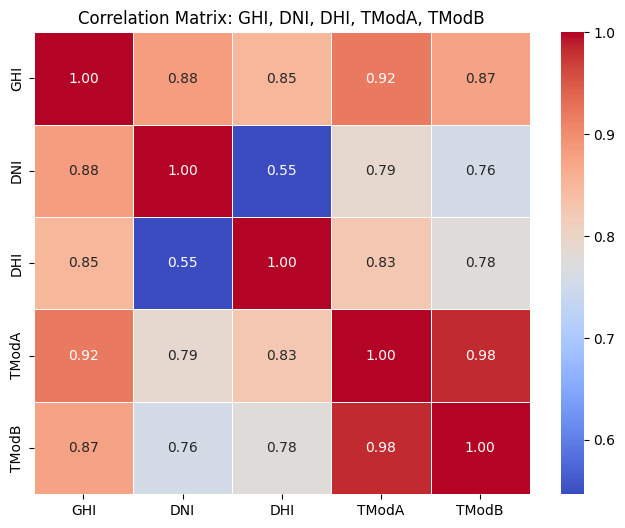


Observations from the Correlation Heatmap:
 - Look for strong positive correlations (values close to +1), which indicate that when one variable increases, the other tends to increase as well.
 - High positive correlations are expected between different measures of solar irradiance (GHI, DNI, DHI).
 - Observe the correlation between solar irradiance components and the module temperatures (TModA, TModB). Higher positive values suggest that increased solar irradiance leads to higher module temperatures.
 - Note any weaker or negative correlations, which might indicate a less direct or inverse relationship.


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_irradiance_temperature_correlation_heatmap(df):
    """
    Generates a heatmap of the correlation matrix for GHI, DNI, DHI, TModA, and TModB.

    Args:
        df (pd.DataFrame): The input DataFrame.
    """
    columns_to_correlate = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']

    # Check if all required columns are present in the DataFrame
    if all(col in df.columns for col in columns_to_correlate):
        correlation_matrix = df[columns_to_correlate].corr()

        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_matrix, annot=True,
                    cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix: GHI, DNI, DHI, TModA, TModB')
        plt.show()

        print("\nObservations from the Correlation Heatmap:")
        print(" - Look for strong positive correlations (values close to +1), which indicate that when one variable increases, the other tends to increase as well.")
        print(" - High positive correlations are expected between different measures of solar irradiance (GHI, DNI, DHI).")
        print(" - Observe the correlation between solar irradiance components and the module temperatures (TModA, TModB). Higher positive values suggest that increased solar irradiance leads to higher module temperatures.")
        print(" - Note any weaker or negative correlations, which might indicate a less direct or inverse relationship.")

    else:
        missing_columns = [
            col for col in columns_to_correlate if col not in df.columns]
        print(
            f"Error: The following required columns are missing from the DataFrame: {missing_columns}")


# Example Usage:
# Assuming you have a DataFrame named 'df'
plot_irradiance_temperature_correlation_heatmap(df.copy())

Scatter plots: WS, WSgust, WD vs. GHI; RH vs. Tamb or RH vs. GHI.



--- Plots for Cleaning = 0 ---


/tmp/ipykernel_179618/3642767508.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df['WD_rad'] = np.radians(group_df['WD'])
/tmp/ipykernel_179618/3642767508.py:51: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


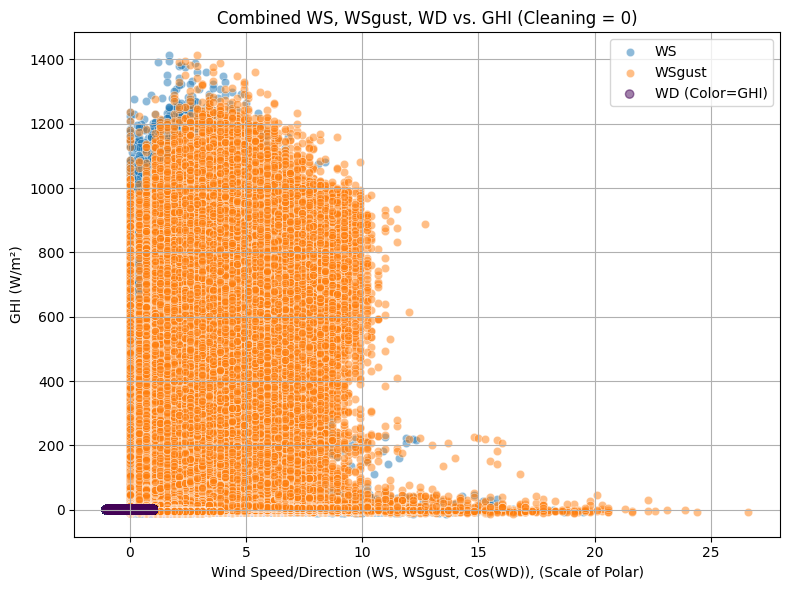

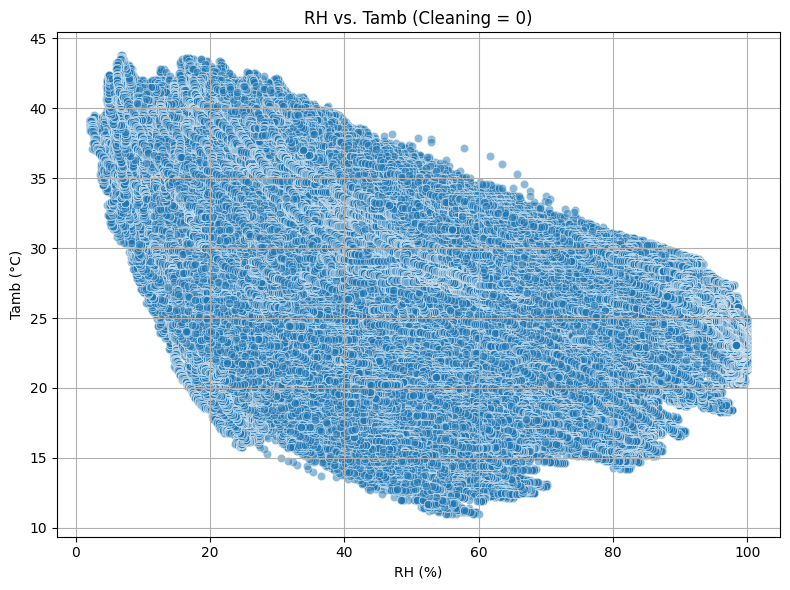


--- Plots for Cleaning = 1 ---


/tmp/ipykernel_179618/3642767508.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df['WD_rad'] = np.radians(group_df['WD'])


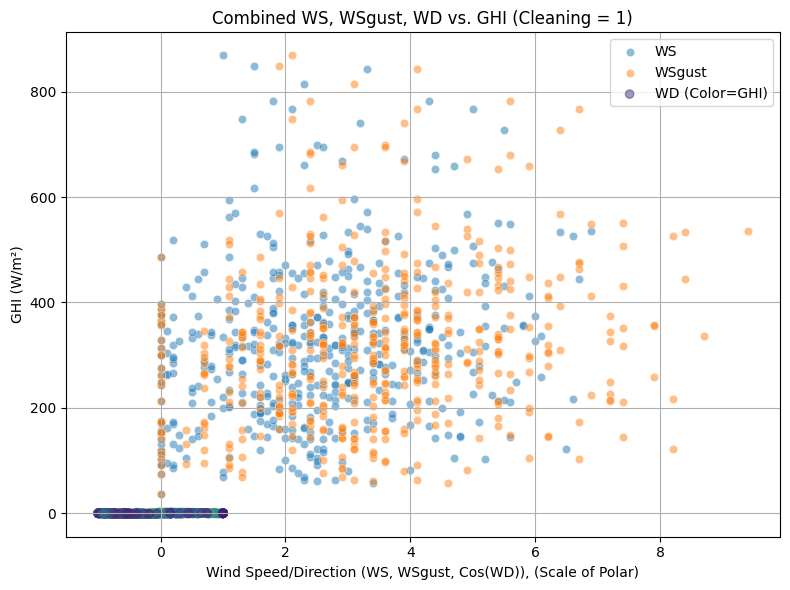

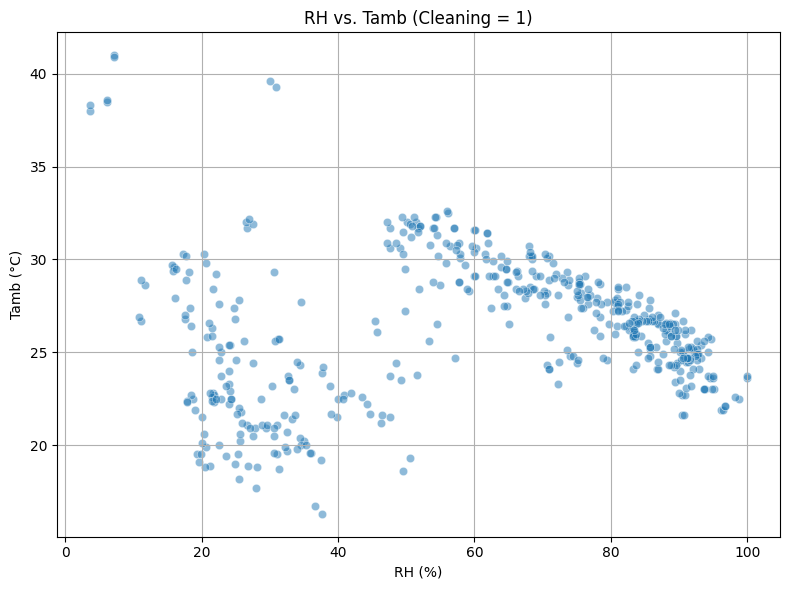

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_combined_and_separate(df, group_column='Cleaning'):
    """
    Generates two separate figures of scatter plots for two groups
    (based on the specified group_column):
    - Figure 1: Combined plot of WS vs. GHI, WSgust vs. GHI, WD vs. GHI
    - Figure 2: Separate plot of RH vs. Tamb

    Args:
        df (pd.DataFrame): The input DataFrame.
        group_column (str, optional): The name of the column to group by.
                                       Defaults to 'Cleaning'.
    """
    if group_column not in df.columns:
        print(
            f"Error: Grouping column '{group_column}' not found in DataFrame.")
        return

    groups = df[group_column].unique()
    if len(groups) != 2:
        print(
            f"Warning: The column '{group_column}' does not have exactly two unique groups. Found: {groups}")

    for group_value in groups:
        group_df = df[df[group_column] == group_value]
        group_label = f"{group_column} = {group_value}"

        print(f"\n--- Plots for {group_label} ---")

        # --- Figure 1: Combined WS, WSgust, WD vs. GHI ---
        if all(col in group_df.columns for col in ['WS', 'WSgust', 'WD', 'GHI']):
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x='WS', y='GHI', data=group_df,
                            label='WS', alpha=0.5)
            sns.scatterplot(x='WSgust', y='GHI', data=group_df,
                            label='WSgust', alpha=0.5)
            group_df['WD_rad'] = np.radians(group_df['WD'])
            plt.scatter(np.cos(group_df['WD_rad']), np.sin(
                group_df['WD_rad']), c=group_df['GHI'], cmap='viridis', alpha=0.5, label='WD (Color=GHI)')
            plt.xlabel(
                'Wind Speed/Direction (WS, WSgust, Cos(WD)), (Scale of Polar)')
            plt.ylabel('GHI (W/m²)')
            plt.title(f'Combined WS, WSgust, WD vs. GHI ({group_label})')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()
            if 'WD_rad' in group_df.columns:
                del group_df['WD_rad']

        else:
            print(
                "Warning: Not all required columns for combined wind vs. GHI plot are present.")

        # --- Figure 2: RH vs. Tamb ---
        if all(col in group_df.columns for col in ['RH', 'Tamb']):
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x='RH', y='Tamb', data=group_df, alpha=0.5)
            plt.title(f'RH vs. Tamb ({group_label})')
            plt.xlabel('RH (%)')
            plt.ylabel('Tamb (°C)')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print(
                "Warning: 'RH' or 'Tamb' columns not found for RH vs. Tamb scatter plot.")


# Example Usage:
# Assuming your DataFrame is named 'df' and the grouping is based on 'Cleaning'
plot_combined_and_separate(df.copy(), group_column='Cleaning')

# If your grouping is based on a different column (e.g., 'Precipitation'), you would change it like this:
# plot_combined_and_separate(df.copy(), group_column='Precipitation')

Wind & Distribution Analysis
Wind rose or radial bar plot of WS/WD.

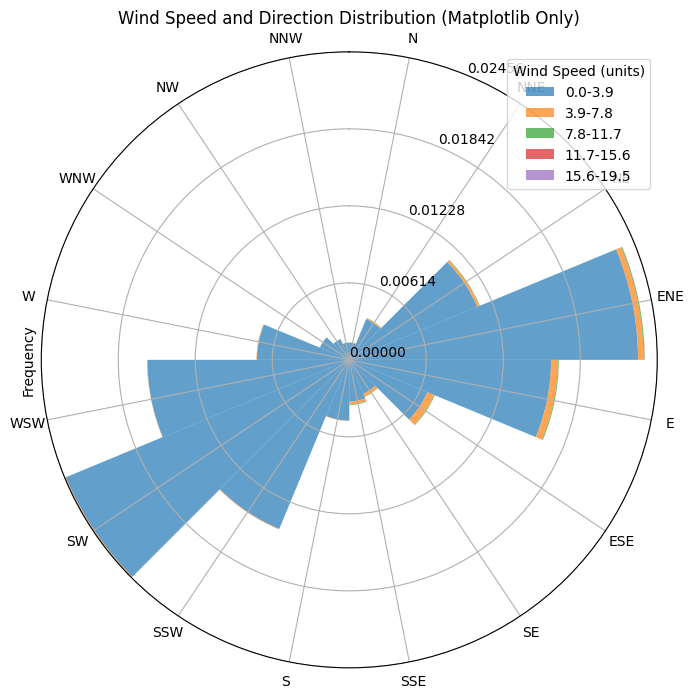

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def plot_wind_rose_matplotlib(df, ws_col='WS', wd_col='WD', num_sectors=16, num_speed_bins=5):
    """
    Generates a wind rose plot using only Matplotlib.

    Args:
        df (pd.DataFrame): The input DataFrame with wind speed and direction columns.
        ws_col (str, optional): The name of the wind speed column. Defaults to 'WS'.
        wd_col (str, optional): The name of the wind direction column (in degrees). Defaults to 'WD'.
        num_sectors (int, optional): The number of directional sectors. Defaults to 16.
        num_speed_bins (int, optional): The number of wind speed bins. Defaults to 5.
    """
    if ws_col not in df.columns or wd_col not in df.columns:
        print(
            f"Error: DataFrame must contain columns '{ws_col}' and '{wd_col}'.")
        return

    wd = df[wd_col].dropna().values
    ws = df[ws_col].dropna().values

    if not wd.size or not ws.size:
        print("Warning: No valid wind speed or direction data available for plotting.")
        return

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

    # Define direction sectors
    theta_edges = np.linspace(0, 2 * np.pi, num_sectors, endpoint=False)
    theta_centers = theta_edges + (np.pi / num_sectors)

    # Define wind speed bins
    speed_limits = np.linspace(ws.min(), ws.max(), num_speed_bins + 1)

    # Count occurrences in each (direction, speed) bin
    counts = np.zeros((num_sectors, num_speed_bins))
    for direction, speed in zip(wd, ws):
        theta_index = int(np.floor((direction % 360) /
                          (360 / num_sectors))) % num_sectors
        speed_index = np.digitize(speed, speed_limits[1:]) - 1
        if 0 <= speed_index < num_speed_bins:
            counts[theta_index, speed_index] += 1

    # Normalize counts by total number of observations for frequency
    total_count = len(wd)
    frequencies = counts / total_count

    # Create the bars
    width = (2 * np.pi) / num_sectors
    for i in range(num_speed_bins):
        bars = ax.bar(theta_centers, frequencies[:, i], bottom=np.sum(frequencies[:, :i], axis=1),
                      width=width, alpha=0.7, label=f'{speed_limits[i]:.1f}-{speed_limits[i+1]:.1f}')

    # Customize plot
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_xticks(theta_edges + (np.pi / num_sectors))
    ax.set_xticklabels(['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW',
                       'NW', 'NNW'] if num_sectors == 16 else [f'{i*360/num_sectors:.0f}°' for i in range(num_sectors)])
    ax.set_yticks(np.linspace(0, frequencies.sum(axis=1).max(), 5))
    ax.set_ylabel("Frequency")
    ax.set_title("Wind Speed and Direction Distribution (Matplotlib Only)")
    ax.grid(True)
    ax.legend(
        title=f"Wind Speed ({df[ws_col].units if hasattr(df[ws_col], 'units') else 'units'})")

    plt.show()


# Plot Wind Rose using Matplotlib
plot_wind_rose_matplotlib(df.copy(), ws_col='WS', wd_col='WD')

Histograms for GHI and one other variable (e.g. WS).

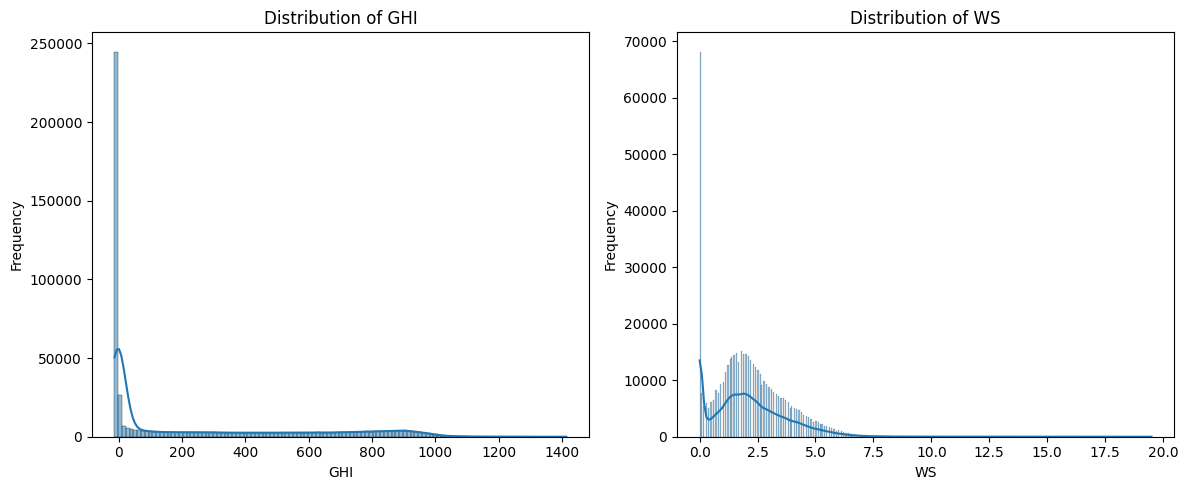

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_histograms(df, var1='GHI', var2='WS'):
    """
    Generates histograms for two specified variables in the DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        var1 (str, optional): The name of the first variable to plot. Defaults to 'GHI'.
        var2 (str, optional): The name of the second variable to plot. Defaults to 'WS'.
    """
    if var1 not in df.columns or var2 not in df.columns:
        print(f"Error: DataFrame must contain columns '{var1}' and '{var2}'.")
        return

    plt.figure(figsize=(12, 5))

    # Histogram for the first variable
    plt.subplot(1, 2, 1)
    # kde=True adds a kernel density estimate line
    sns.histplot(df[var1], kde=True)
    plt.title(f'Distribution of {var1}')
    plt.xlabel(var1)
    plt.ylabel('Frequency')

    # Histogram for the second variable
    plt.subplot(1, 2, 2)
    sns.histplot(df[var2], kde=True)
    plt.title(f'Distribution of {var2}')
    plt.xlabel(var2)
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


# Example Usage:
# Assuming your DataFrame is named 'df'
plot_histograms(df.copy(), var1='GHI', var2='WS')

# You can choose a different second variable, for example, Tamb:
# plot_histograms(df.copy(), var1='GHI', var2='Tamb')

# Or ModA:
# plot_histograms(df.copy(), var1='GHI', var2='ModA')

Temperature Analysis
Examine how relative humidity (RH) might influence temperature readings and solar radiation.

#Influence of Relative Humidity (RH):

Temperature: Generally inverse relationship. Higher temperature means lower RH (air can hold more moisture). High RH makes warm temperatures feel hotter (less sweat evaporation).
Solar Radiation: Higher RH often leads to more scattering and absorption of sunlight due to water vapor, haze, and cloud formation (which RH is crucial for). This typically results in an inverse correlation: higher RH, lower solar radiation reaching the surface.
To analyze this in your data:

Correlations: Check how strongly RH is linearly related to temperature and solar radiation.
Scatter Plots: Visualize these relationships, potentially coloring points by the third variable (e.g., RH vs. Tamb colored by GHI).
Grouped Stats: Compare average temperature and solar radiation across different RH ranges (low, medium, high).

Bubble Chart
GHI vs. Tamb with bubble size = RH or BP.

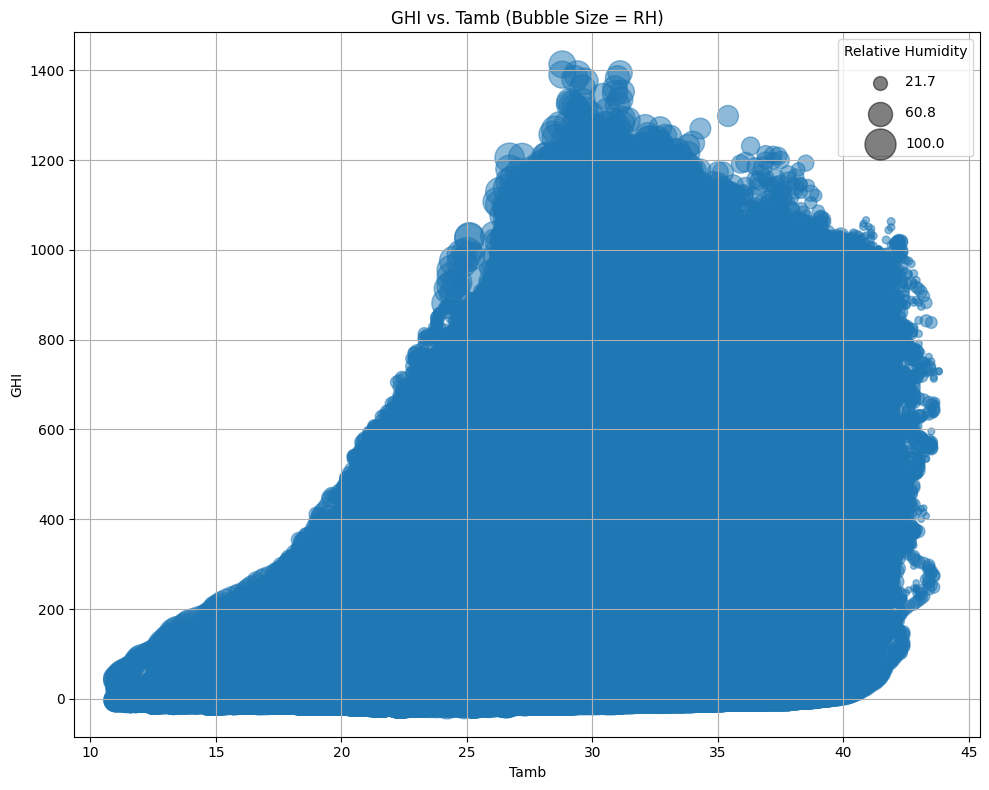

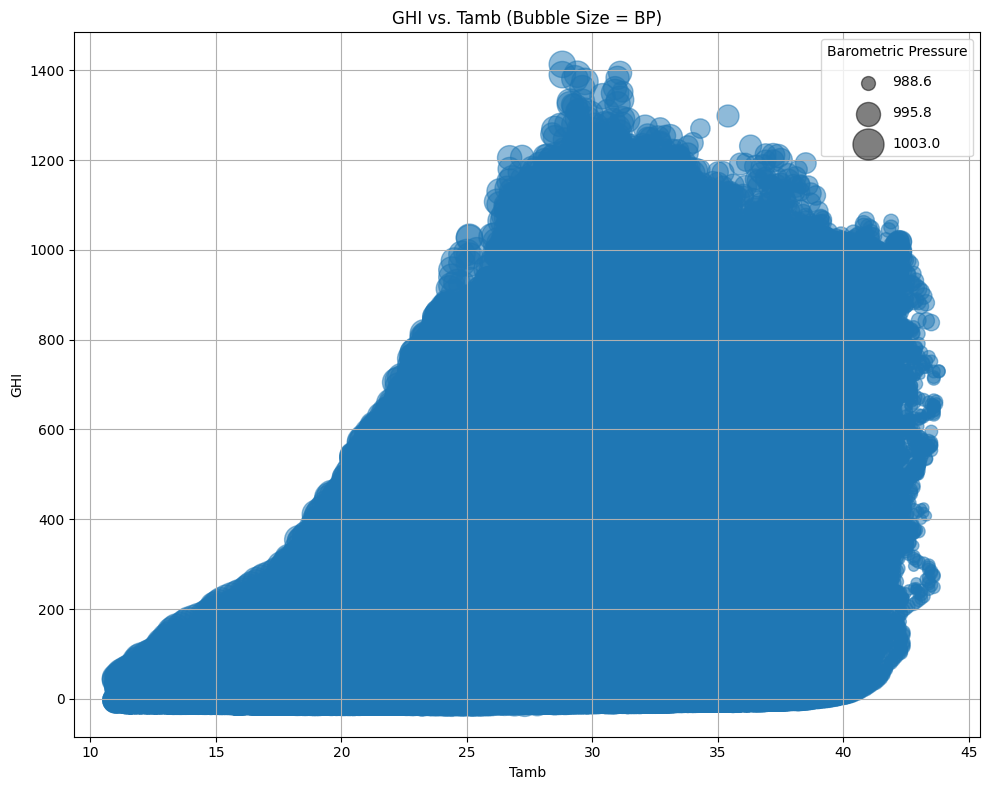

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_bubble_chart(df, x_col='Tamb', y_col='GHI', size_col=None, size_label='', title=''):
    """
    Generates a bubble chart to visualize the relationship between two variables,
    with bubble size representing a third variable.

    Args:
        df (pd.DataFrame): The input DataFrame.
        x_col (str, optional): The column name for the x-axis (e.g., 'Tamb').
                               Defaults to 'Tamb'.
        y_col (str, optional): The column name for the y-axis (e.g., 'GHI').
                               Defaults to 'GHI'.
        size_col (str, optional): The column name for the bubble size (e.g., 'RH' or 'BP').
                                 Defaults to None.
        size_label (str, optional): Label for the size legend. Defaults to ''.
        title (str, optional): The title of the plot. Defaults to ''.
    """

    if x_col not in df.columns or y_col not in df.columns:
        print(
            f"Error: DataFrame must contain columns '{x_col}' and '{y_col}'.")
        return

    plt.figure(figsize=(10, 8))

    if size_col:
        if size_col not in df.columns:
            print(f"Error: DataFrame must contain column '{size_col}'.")
            return

        # Normalize size to a reasonable range for plotting
        size = (df[size_col] - df[size_col].min()) / (df[size_col].max() -
                                                      df[size_col].min()) * 500  # Adjust 500 for bubble size
        scatter = plt.scatter(x=df[x_col], y=df[y_col], s=size, alpha=0.5)

        # Create a legend for the bubble sizes
        sizes = [100, 300, 500]  # Example sizes
        size_labels = [df[size_col].min() + (df[size_col].max() -
                                             df[size_col].min()) * s / 500 for s in sizes]
        for s, l in zip(sizes, size_labels):
            plt.scatter([], [], s=s, alpha=0.5, c='k', label=f'{l:.1f}')
        plt.legend(scatterpoints=1, labelspacing=1.2, title=size_label)

    else:
        plt.scatter(x=df[x_col], y=df[y_col], alpha=0.5)

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example Usage:
# Assuming your DataFrame is named 'df'


# 1. GHI vs. Tamb with bubble size = RH
plot_bubble_chart(df.copy(), x_col='Tamb', y_col='GHI', size_col='RH', size_label='Relative Humidity',
                  title='GHI vs. Tamb (Bubble Size = RH)')

# 2. GHI vs. Tamb with bubble size = BP
plot_bubble_chart(df.copy(), x_col='Tamb', y_col='GHI', size_col='BP', size_label='Barometric Pressure',
                  title='GHI vs. Tamb (Bubble Size = BP)')